This notebook calculates the distance to the nearest 10^5.5 and 10^ 6.5 Msun molecular cloud from the locations of each of the SNe located within 150pc maps.

In [9]:
#import packages and initialize settings
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.io import ascii
from astropy.table import Table
from progressbar import progressbar
from astropy.wcs import WCS
from reproject import reproject_interp

import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
from FindNearestMC import nearestMCMethodSigMol

In [10]:
# Unpack master table to get SNe information
database = Table.read('../Data/3.SNe+GalData.csv', format = "csv")

database[0:1]

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile,PACovFile,IFRFile,MixedMaps,IFRResizedMaps,MassMaps
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str80,str112,str97,str37,str54,str35
circinus,SN1996cr,II,213.2918,-65.3457,86.56761411031889,84.63433198287285,186.84804,2.137819,34.56537,0.002032163908078,213.29124,-65.33915,4.2,36.74,64.3,262.49515,7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/ESO097-013_alphaCO21_scaling.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_coverage2d.fits,/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/z0mgs/eso097-013_w1_gauss7p5.fits,../Data/MixedMaps/circinus_Mixed.fits,../Data/ReprojectedInfraredMaps/circinus_reshaped.fits,../Data/MassMaps/circinus_Mass.fits


[None, array([0.01364605]), array([0.55655997]), array([0.01321117]), array([0.00491407]), array([0.01275901]), array([0.1489542]), array([0.19534568]), array([0.35979567]), array([0.01287783]), array([0.01284268]), array([1.22508167]), array([0.01592836]), array([0.00761477]), array([0.00716833]), array([0.00421925]), None, array([0.07117317]), array([0.00321098]), array([0.0076644]), array([0.58246467]), array([0.01154423]), array([0.00611075]), array([0.00733605]), array([0.01245564]), array([0.01044295]), array([0.0040826]), array([0.00808865]), array([0.01097162]), array([0.02066585]), array([0.08586097]), array([0.03508382]), array([0.02765949]), array([0.0155404]), array([0.03955008]), array([0.02026862]), array([0.2480944]), array([0.10081377]), array([0.0106565]), array([0.00660132]), array([0.06650442]), array([0.01621761]), array([0.03209613]), array([0.38714994]), array([0.00946752]), array([0.29470551]), array([0.10821323]), array([0.37426845]), None, None, array([5800.10100662]), array([0.01400941]), array([0.01271513]), array([0.00453499]), array([0.00497956]), array([0.00238751]), array([0.05432539]), array([0.00023186]), array([0.0098961]), array([0.01070017]), array([0.99123115])]

[0.03220571, 0.03057009, 0.31916941, 0.75480179, 0.02805144]

In [11]:
database.sort("galaxy")
gal_group = database.group_by("galaxy")
print(len(gal_group))
for i in range(len(gal_group)):
    print(gal_group["SN_name"][i])

63
SN1996cr
SN1940E
SN2013ej
SN2018ivc
SN1995V
SN1999eu
SN1992bd
SN2001du
SN1983V
SN2012fr
SN1985P
SN1935C
SN2009ib
SN2005df
SN1984J
SN1986L
ASASSN-14ha
SN2010el
SN1999em
SN2017gax
SN1993Z
SN2008eh
SN2003jg
SN2012A
SN1973R
SN1989B
SN2016cok
SN2009hd
SN1986I
SN2014L
SN1967H
SN1972Q
SN1961I
SN1926A
SN1999gn
SN2006ov
SN2020jfo
SN1964F
SN2014dt
SN1959E
SN2006X
SN2020oi
SN2019ehk
SN1901B
SN1979C
SN2012cg
SN2020nvb
SN1988M
SN1960F
SN1981B
SN1989M
SN1988A
SN2011ja
SN1986G
SN2016adj
SN1983N
SN1968L
SN1923A
SN1950B
SN1957D
SN2007it
SN2005at
SN2008bk


In [12]:
centerCoords = [(database["orient_ra"][i], database["orient_dec"][i]) for i in range(len(database))]    
SNe, SNra, SNdec  = database["SN_name"], database["SN_ra"], database["SN_dec"]
SNra  = np.array(SNra)
SNdec = np.array(SNdec)
massCutA = 10**5.5
massCutB = 10**6.5
gal_group.groups.indices
print(gal_group["galaxy"])

 galaxy 
--------
circinus
 ngc0253
 ngc0628
 ngc1068
 ngc1087
 ngc1097
 ngc1097
 ngc1365
 ngc1365
 ngc1365
     ...
 ngc4945
 ngc5128
 ngc5128
 ngc5236
 ngc5236
 ngc5236
 ngc5236
 ngc5236
 ngc5530
 ngc6744
 ngc7793
Length = 63 rows


In [14]:
# remove duplicate galaxies, grouping SNe together in their own lists.

SNr, SNd, SNa = [],[],[]
gala, imgs, errs, alco, cocs, pans, incl, gdis, SNrs, SNdc, SNea = [],[],[],[],[],[],[],[],[],[],[]

for i in range(len(database)):
    gal = database["galaxy"][i]
    img = database["ImageFile150"][i]
    ers = database["ErrFile150"][i]
    aco = database["AlphaCOFile"][i]
    ccs = centerCoords[i]
    pas = database["orient_posang"][i]
    inc = database["orient_incl"][i]
    gds = database["dist"][i]
    SNr.append(SNra[i])
    SNd.append(SNdec[i])
    SNa.append(SNe[i])
    
    if (i+1) in gal_group.groups.indices:
        print(i+1, gal, aco, SNr, SNd, SNa, ccs)
        gala.append(gal)
        imgs.append(img)
        errs.append(ers)
        alco.append(aco)
        cocs.append(ccs)
        pans.append(pas)
        incl.append(inc)
        gdis.append(gds)
        SNrs.append(SNr)
        SNdc.append(SNd)
        SNea.append(SNa) 
        SNr, SNd, SNa = [],[],[]
    else: pass

1 circinus /data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/ESO097-013_alphaCO21_scaling.fits [213.2918] [-65.3457] ['SN1996cr'] (213.29124, -65.33915)
2 ngc0253 /data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/NGC0253_alphaCO21_scaling.fits [11.8783] [-25.2934] ['SN1940E'] (11.887966, -25.288443)
3 ngc0628 /data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/NGC0628_alphaCO21_scaling.fits [24.2007] [15.7586] ['SN2013ej'] (24.173855, 15.783643)
4 ngc1068 /data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/NGC1068_alphaCO21_scaling.fits [40.672] [-0.0088] ['SN2018ivc'] (40.66973, -0.0132779)
5 ngc1087 /data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/NGC1087_alphaCO21_scaling.fits [41.6115] [-0.4988] ['SN1995V'] (41.60492, -0.498717)
7 ngc1097 /data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/NGC1097_alphaCO21_scaling.fits [41.5866, 41.5792] [-30.3184, -30.2756] ['SN1999eu', 'SN1992bd'] (41.578957, -30.274675)
10 ngc1365 /data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/NGC1365_alphaCO21_scaling.fits [53.3713,

In [15]:
#for i in range(len(gal_group.groups.indices)-1):
print(gala[3], imgs[3], alco[3])
print(gdis)
print(len(gala))
print()

ngc1068 /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1068/ngc1068_7m+tp_co21_150pc_broad_mom0.fits /data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/NGC1068_alphaCO21_scaling.fits
[4.2, 3.7, 9.84, 13.97, 15.85, 13.58, 19.57, 18.63, 15.28, 19.44, 17.69, 11.7, 19.4, 23.15, 14.06, 10.86, 11.32, 13.1, 16.99, 15.21, 16.2, 15.1, 14.86, 16.25, 21.0, 3.47, 3.69, 4.89, 12.27, 9.39, 3.62]
31



In [16]:

nearestSigMol = []
for i in range(len(gala)):
    if incl[i] == 90.0:
        incl[i]=80.0
    nearSM = nearestMCMethodSigMol(gala[i], imgs[i], errs[i], alco[i], cocs[i], pans[i], incl[i], gdis[i], SNrs[i], SNdc[i], SNea[i])
    nearestSigMol.append(nearSM)


at SigMol cutoff A for circinus
Pixels with SigMol > 7.9 5648
Nearest sigmol [32.20571075] circinus
done with circinus  
at SigMol cutoff A for ngc0253
Pixels with SigMol > 7.9 21834
Nearest sigmol [30.57009157] ngc0253
done with ngc0253  
at SigMol cutoff A for ngc0628
Pixels with SigMol > 7.9 622960
Nearest sigmol [97.87335683] ngc0628
done with ngc0628  
No file for  ngc1068
at SigMol cutoff A for ngc1087
Pixels with SigMol > 7.9 43592
Nearest sigmol [13.6460475] ngc1087
done with ngc1087  
at SigMol cutoff A for ngc1097
Pixels with SigMol > 7.9 43073
Nearest sigmol [279.64329546  13.21116559] ngc1097
done with ngc1097  
at SigMol cutoff A for ngc1365
Pixels with SigMol > 7.9 72021
Nearest sigmol [175.45337986  12.75901358 373.02509813] ngc1365
done with ngc1365  
at SigMol cutoff A for ngc1433
Pixels with SigMol > 7.9 35392
Nearest sigmol [186.10069797] ngc1433
done with ngc1433  
at SigMol cutoff A for ngc1511
Pixels with SigMol > 7.9 21561
Nearest sigmol [438.87239045] ngc1511
do

/home/mayker.1/Desktop/PythonFunctions/FindNearestMC.py:186: RuntimeWarning: invalid value encountered in multiply
  sigmol = aco * inten * np.cos(incl * np.pi/180.0)


at SigMol cutoff A for ngc4945
Pixels with SigMol > 7.9 20691
Nearest sigmol [40.30073184] ngc4945
done with ngc4945  
at SigMol cutoff A for ngc5128
Pixels with SigMol > 7.9 11461
Nearest sigmol [14.00940735 12.7151346 ] ngc5128
done with ngc5128  
at SigMol cutoff A for ngc5236
Pixels with SigMol > 7.9 540621
Nearest sigmol [7.07382318 0.23186175 4.97955839 2.38751306 4.5349939 ] ngc5236
done with ngc5236  
at SigMol cutoff A for ngc5530
Pixels with SigMol > 7.9 34655
Nearest sigmol [32.92384217] ngc5530
done with ngc5530  
at SigMol cutoff A for ngc6744
Pixels with SigMol > 7.9 151981
Nearest sigmol [10.7001712] ngc6744
done with ngc6744  
at SigMol cutoff A for ngc7793
Pixels with SigMol > 7.9 3466
Nearest sigmol [172.56550796] ngc7793
done with ngc7793  


In [17]:
n55A = []
for i in range(len(nearestSigMol)):
    if(type(nearestSigMol[i])!= np.float64 and type(nearestSigMol[i]) != float):
        for j in range(len(nearestSigMol[i])):
            n55A.append(nearestSigMol[i][j])
    else:
        n55A.append(nearestSigMol[i])
#print(n55A)


In [18]:
with open("../Data/NearestMCtoSNe.txt", "w") as textFile:
    print("# Nearest7.9SigMolArrayDistances(in pc)", file=textFile)
    print(n55A, file=textFile)

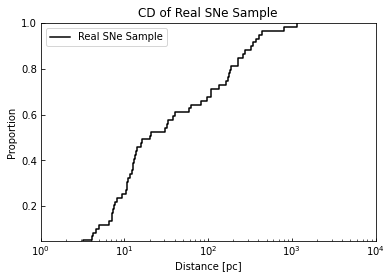

In [19]:
import seaborn as sns

fig = plt.figure(figsize = (6,4))
sns.ecdfplot(n55A,color = "black",  label="Real SNe Sample")
plt.xscale('log')
plt.legend(loc='best')
plt.ylim (0.05,1.0)
plt.xlim(1,10000)
# plt.axvline(x = 50,ymin = 0,ymax = 1, color='grey', ls = '--')
plt.tick_params(axis = "both", which = "both", direction = "in")
plt.title("CD of Real SNe Sample")
plt.xlabel("Distance [pc]")
fig.savefig("../Figures/RealSNeCDFs55.png", dpi=300)
plt.show()
plt.close()

In [20]:
modelResults = Table.read("../Data/AllModels.csv", format = 'csv')

def cleanModels(modelData):
    keep = np.where(np.isfinite(modelData))
    clean = modelData[keep]
    #clean = np.clip(clean, 1, None)
    clean = np.asarray(clean)
    return(clean)

n55m1 = cleanModels(modelResults["n55Mod1"])
n55m2 = cleanModels(modelResults["n55Mod2"])
n55m3 = cleanModels(modelResults["n55Mod3"])
n55m4 = np.concatenate((n55m2[0:1914],n55m3[1914:-1]))

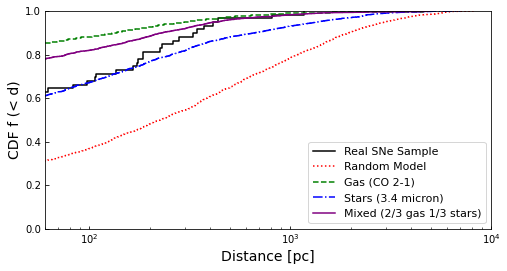

In [27]:

fig = plt.figure(figsize = (8,4))
sns.ecdfplot(n55A,color = "black",  label="Real SNe Sample")
sns.ecdfplot(n55m1, color = "red", ls = ":", label="Random Model")
sns.ecdfplot(n55m2, color = "green",ls = "--",  label="Gas (CO 2-1)")
sns.ecdfplot(n55m3, color = "blue",  ls = "-.",label="Stars (3.4 micron)")
sns.ecdfplot(n55m4, color = "purple", ls = "-", label="Mixed (2/3 gas 1/3 stars)")
plt.xscale('log')
plt.legend(loc='best', fontsize = 11)
plt.ylim (0.00,1.0)
plt.xlim(60,10000)
plt.axvline(x = 50,ymin = 0,ymax = 1, color='grey',
            ls = '--')
plt.tick_params(axis = "both", which = "both", direction = "in")
plt.xlabel("Distance [pc]", fontsize = 14)
plt.ylabel("CDF f (< d)", fontsize = 14)
fig.savefig("../Figures/ModelCDFs55.png", dpi=300)
plt.show()
plt.close()